# Building Jupyter notebook workflows with scrapbook
One principle of good software design is to limit the functionality and scope of a software component. Jupyter notebooks can easily grow in size and complexity, and it can become tempting to put all of the logic for a complex workflow in one notebook. To limit a notebook to a single task or purpose requires a way to communicate data between notebooks. Since each notebook runs in a separate kernel, building a workflow of notebooks requires a way to persist data from one notebook and then read it in another. There are many common options for this:

 * Saving data to CSV/Pickle/Parquet, etc.
 * Saving to a database (relational or object store)
 * Inter-process communication

All of these options have one common problem: the notebook and the data are separate. It would be useful to have the data and notebook co-exist in one place. This is what the [scrapbook](https://nteract-scrapbook.readthedocs.io/) library from [nteract](https://nteract.io) does. Scrapbook allows a notebook author to persist some of the data from a notebook session into the notebook file itself, then other notebooks (or Python applications) can read the notebook files and use the data.

## Building workflows
Instead of one notebook that executes an entire workflow, smaller notebooks can be created, [unit tested](https://www.wrighters.io/unit-testing-python-code-in-jupyter-notebooks/), and then [parameterized and executed with papermill](https://www.wrighters.io/parameters-jupyter-notebooks-with-papermill/). The outputs of each notebook can then be read by subsequent notebooks in the workflow. Each notebook executes and persists any results to be used by the next step in the process. Scrapbook persists the values in the notebook file itself. Later in the workflow, the notebook file is read and the values retreived. Any Python objects or display values can be persisted, as long as they can be serialized. The library includes some basic encoders, and new ones can be created easily.


### Installation
First, to use scrapbook, you have to install it.

```
pip install scrapbook
```

or if you want to be able to install all the optional dependencies for remote servers like Amazon S3 or Azure:
```
pip install scrapbook[all]
```

### How does it work?
Scrapbook takes advantage of the fact that notebooks are just [JSON documents](https://nbformat.readthedocs.io/en/latest/) with the ability to store different types of outputs for cells. The best way to understand this is to look at a simple example.

To do this, create a source notebook and import the scrapbook library.


In [5]:
import scrapbook as sb

Now, in a cell, define a value.

In [8]:
x = 1

When we save the notebook, the cell above (in the JSON .ipynb file) will look something like this (you may see a different id and execution count):
```json
{
   "cell_type": "code",
   "execution_count": 3,
   "id": "6b5d2b33",
   "metadata": {},
   "outputs": [],
   "source": [
    "x = 1"
   ]
}
```

Now, in a subsequent cell, we can use ```scrapbook``` to ```glue``` the value of ```x``` to the current notebook.

In [6]:
sb.glue("x", x)

After saving the notebook, the cell above (in the JSON .ipynb file) will look something like this:
```json
{
   "cell_type": "code",
   "execution_count": 3,
   "id": "228fc7d4",
   "metadata": {},
   "outputs": [
    {
     "data": {
      "application/scrapbook.scrap.json+json": {
       "data": 1,
       "encoder": "json",
       "name": "x",
       "version": 1
      }
     },
     "metadata": {
      "scrapbook": {
       "data": true,
       "display": false,
       "name": "x"
      }
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "sb.glue(\"x\", x)"
   ]
  }
```

While you don't see any output in your notebook for this cell, there still is data hidden in the cell outputs as an encoded numeric value. Metadata is saved as well so that scrapbook can properly read the value later.

Again, if the notebook up to this point has been saved, we can now read the notebook using ```scrapbook``` and use it to fetch the value out of the notebook file. Usually, we do this in a different notebook or Python application, but it does work inside the same notebook (as long as it's been saved to disk).

In [7]:
nb = sb.read_notebook("scrapbook_and_jupyter.ipynb")

The notebook object has a number of attributes which correspond directly to the JSON scheme of a notebook file, just as documented in the ```nbformat``` [docs](https://nbformat.readthedocs.io/en/latest/). But it also has a few extra methods for dealing with ```scraps```, the values that have been glued to the notebook. You can see the scraps directly:

In [9]:
nb.scraps

Scraps([('x', Scrap(name='x', data=1, encoder='json', display=None))])

Or see them in a ```DataFrame```.

In [10]:
nb.scrap_dataframe

,name,data,encoder,display,filename
0,x,1,json,None,scrapbook_and_jupyter.ipynb


And you can fetch the value easily.

In [12]:
x = nb.scraps['x'].data
x

1

Now that we've covered the basics, let's put the work together for a more complicated example.

## A sample workflow
For this workflow, let's build on the example for the article on [papermill](https://www.wrighters.io/parameters-jupyter-notebooks-with-papermill/). Let's say we want to run a single notebook for a number of stock tickers and look for any symbols that are within a threshold of their All Time High price (ATH). Then, we will run a second notebook that reads all the notebooks from the first step, and only shows data from those tickers within the threshold.

In the example we will use more ```scrapbook``` features. 

### The first step of the workflow
The [source notebook](https://github.com/wrighter/python_blogposts/tree/main/tools/scrapbook_example_source.ipynb) will be executed once for each ticker. To keep things simple (and fast), the notebook will generate fake data for this example, but could easily be connected to real data. The notebook generates a price series, an All Time High (ATH) price, and then determines if the last price is within a threshold of the ATH, along with a plot. The notebook saves the plot, the source data, and a few values.

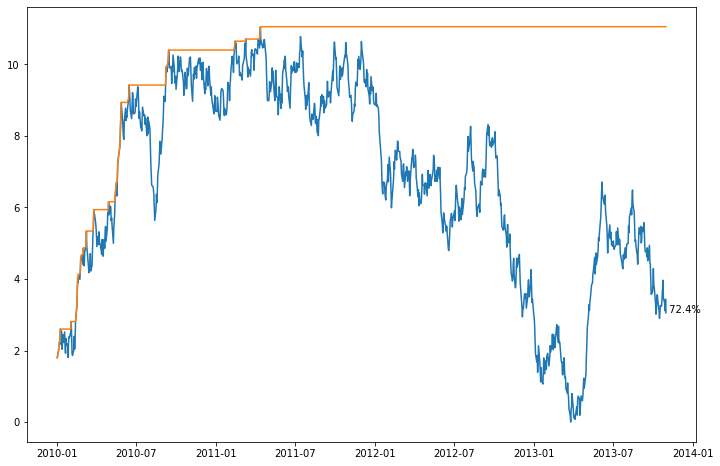

In [13]:
length = 1000
symbol = "XYZ"
d = {
    "a": 1,
    "b": 2,
}
threshold = 0.05 # 5%

import pandas as pd
import numpy as np
import scrapbook as sb

import matplotlib.pyplot as plt

# generate a DataFrame that has synthetic price information
idx = pd.date_range(start='20100101', periods=length, freq='B')
prices = pd.DataFrame({'price' : np.cumsum(np.random.random(length) - .5)}, index=idx)
# normalize to always be above 0
prices['price'] += abs(prices['price'].min())
prices['ATH'] = prices['price'].expanding().max()

distance = 1 - prices.iloc[-1]['price']/prices.iloc[-1]['ATH']
if distance <= threshold:
    close_to_ath = True
else:
    close_to_ath = False
    
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(prices['price'])
ax.plot(prices['ATH'])
ax.text(prices.index[-1], prices['price'].iloc[-1], f"{distance * 100: .1f}%");

### Gluing different types
We've already covered the ```glue``` method for a basic type. If the type passed in can be serialized using one of the built in encoders, it will be. To preserve numeric types, they will be encoded as JSON.

In [14]:
sb.glue("length", length)                           # numeric - int (stored as json)
sb.glue("symbol", symbol)                           # text
sb.glue("distance", distance)                       # numeric - float
sb.glue("close_to_ath", close_to_ath)               # bool

You can also specify the encoder for more complex types. At this time (as of version 0.5 of scrapbook), there are encoders included for json, pandas, text, and display. 


There is also a ```display``` parameter. This determines whether the value is visibile in the notebook when it is glued. By default you will not see the value in the notebook when it is stored.

The display encoder will only save the displayed value, not the underlying data that backs it. This might make sense for visual types that can have a lot of data needed to create the result, but where you only want the visual result, not the data. For example, if we only wanted our plot from above, we could persist just the display. We don't have an encoder that will save a matplotlib.figure.Figure, but since it can be displayed, it can be stored that way.



{'a': 1, 'b': 2}

Scrap of type <class 'matplotlib.figure.Figure'> has no supported encoder registered


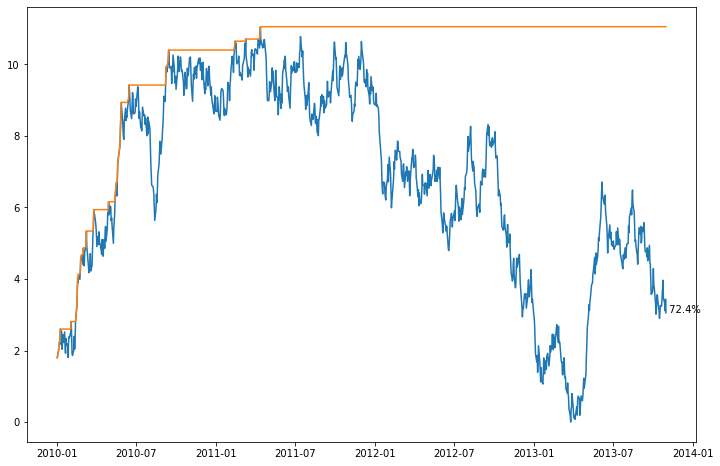

In [18]:
# with display set, this will display the value, see it in the output below?
sb.glue("dj", d, encoder="json", display=True)  
sb.glue("prices", prices, encoder="pandas")
sb.glue("message", "This is a message", encoder="text")

try:
    sb.glue("chart", fig)
except NotImplementedError as nie:
    print(nie)
# but we can store the display result (will also display the value)
sb.glue("chart", fig, encoder="display")

Now that a parameterized notebook exits and can be executed with different values, we run it with a simple script (or from the command line) for a number of tickers. For example, we might do something like this in the directory where the notebook file exists (with some fake tickers):

```shell
mkdir tickers
for s in AAA ABC BCD DEF GHI JKL MNO MMN OOP PQD XYZ PDQ
do
    papermill -p symbol $s scrapbook_example_source.ipynb tickers/${s}.ipynb
done
```
At this point, assuming there were no failures in the notebooks, there should be a directory of notebook files with data for each ticker.

### The second worfklow step
Our [second notebook](https://github.com/wrighter/python_blogposts/tree/main/tools/scrapbook_example_dest.ipynb) in the workflow loads each of the workbooks generated above, creating a report of those that are within the threshold.

An additional API is used here.  The ```read_notebooks``` method, which allows us to fetch the notebooks all at once. We'll iterate through them and display the ticker and distance for each notebook, and show the chart for each that is within the threshold.

In [21]:
source_dir = "tickers"
sbook = sb.read_notebooks(source_dir)

Now we have a scrapbook of notebooks (```sbook```) that we can iterate through.

AAA    49.81%
ABC    60.51%
BCD    0.13%


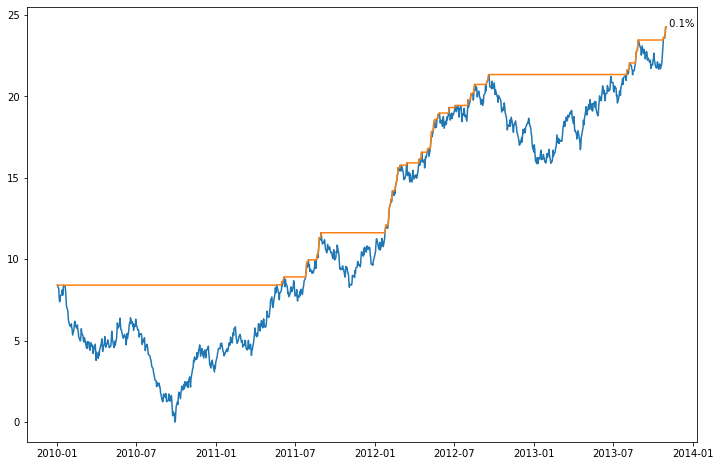

DEF    94.09%
FB     80.13%
GHI    19.65%
JKL    44.80%
MMN    100.00%
MNO    2.42%


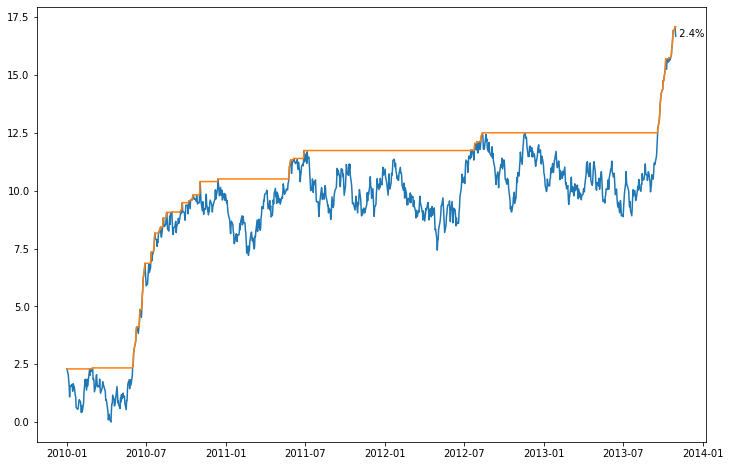

OOP    24.18%
PDQ    93.33%
PQD    18.19%
XYZ    44.14%


In [22]:
for nb in sbook.notebooks:
    print(f"{nb.scraps['symbol'].data: <5} {nb.scraps['distance'].data * 100: .2f}%")
    if nb.scraps['close_to_ath'].data:
        display(nb.scraps['chart'].display['data'], raw=True)   

### Reglue
One last API to mention is ```reglue```. You can use this method on an existing notebook to "re"-glue a scrap into the current notebook. You can also rename the scrap.

This is probably most useful if you want to propogate some data forward to another notebook that will be reading the current notebook.

Another use of ```reglue``` is to display visual elements.

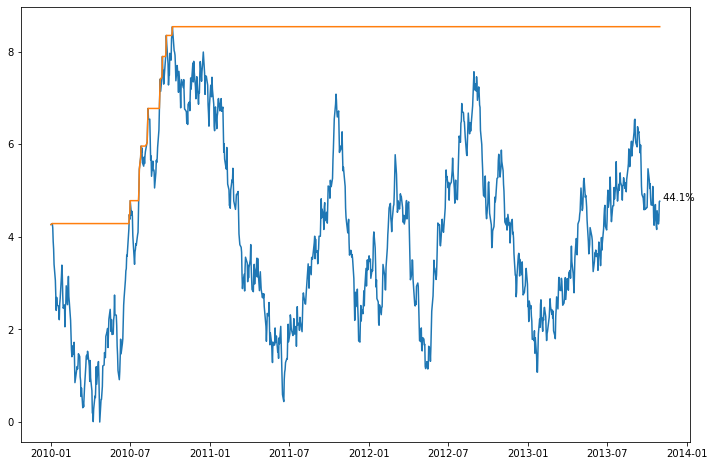

In [27]:
nb.reglue("length", "length2") # new name
nb.reglue("chart")

### Some possible drawbacks to scrapbook
Using notebooks to store your data is not an optimized way to store data. There are a number of potential issues with choosing a tool like this:
 * It obviously doesn't scale like a relational or object database.
 * Tool support is minimal, for example there is no easy way to view or manipulate the internal data with an editor like with a CSV file or other formats.
 * It also does not have good tool support for editing data manually, especially for more complex types that will be large chunks of Base64 encoded text.

You won't want to use a tool like this to support large amounts of data produced by notebooks. But for smaller amounts of data, especially concise summaries or outputs of a notebook, it provides the highly desirable feature of keeping data with the notebook that generated it.

### Extending scrapbook
You can extend the framework by writing your own encoders. The documents show a simple example of this, so if you end up with data that can't be encoded using the default encoders, you can create your own.

### Summary
Scrapbook is a useful small library for keeping notebooks and the data they produce together in one file. It integrates well with papermill and is especially useful for running workflows of multiple notebooks that feed data to one another. 
